# Projeto de redes neurais: modelo de análise e avaliação de asteroides
Autora: Renata Leite Leandro

## Setup:
Alguns pacotes que usaremos neste projeto são:

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [53]:
dados = pd.read_csv('neo.csv')    # Leitura do dataset    

## Introdução ao dataset
Utilizando o método '.head', podemos observar as 5 primeiras linhas do dataset, o que possibilita também uma análise inicial das colunas que compõem o conjunto de dados. Observe:

In [54]:
dados.head()    # Mostra as 5 primeiras linhas do dataset de treino

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


Através dessa pequena amostra do conjunto de dados, deve-se compreender, primeiramente, cada uma das 10 features (ou colunas) presentes no dataset, que será posteriormente separado em treino e teste. Temos, então, que:

- id: ID exclusivo para cada asteroide;
- name: nome do asteroide dado pela NASA;
- est_diameter_min: diâmetro mínimo estimado em km;
- est_diameter_max: diâmetro máximo estimado em km;
- relative_velocity: velocidade relativa à Terra;
- miss_distance: distância perdida em km;
- orbiting_body: planeta que o asteroide orbita;
- sentry_object: incluído no sentry, sistema automatizado de monitoramento de colisões;
- absolute_magnitude: descreve a luminosidade intrínseca;
- hazardous: feature booleana que mostra se o asteroide é prejudicial ou não.

Juntamente à análise das 90836 linhas que compõem tal dataset, o objetivo deste projeto será a criação de uma rede neural que, com base na observação das diferentes características de cada asteroide, será capaz de predizer aqueles que são potencialmente prejudiciais e aqueles que não o são.

# Limpeza de dados
Embora o dataset utilizado tenha sido previamente tratado, é importante verificar a qualidade da limpeza dos dados para evitar futuros problemas. Para isso, devemos, inicialmente, investigar se há alguma categoria destoante. Veja abaixo:

In [55]:
print(' Valores presentes em orbiting_body')
print(pd.Series(dados.orbiting_body.unique()))
print('\n Valores presentes em sentry_object')
print(pd.Series(dados.sentry_object.unique()))
print('\n Valores presentes em hazardous')
print(pd.Series(dados.hazardous.unique()))

 Valores presentes em orbiting_body
0    Earth
dtype: object

 Valores presentes em sentry_object
0    False
dtype: bool

 Valores presentes em hazardous
0    False
1     True
dtype: bool


Em seguida, podemos examinar se existem valores nulos no dataset:

In [56]:
dados.isnull().sum()    # Retorna a soma dos valores nulos encontrados

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

Por último, é importante averiguar a presença de valores numéricos aberrantes no dataset, que podem ser procurados através da seguinte tabela:

In [57]:
dados.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


# Análise de dados
Agora que sabemos que nosso dataset encontra-se, de fato, devidamente limpo, podemos focar na análise de dados, essencial para encontrar as features relevantes para a construção de nosso modelo. Faremos isso através da montagem de gráficos, que auxiliarão na visualização de informações e associação de features.

In [58]:
sns.set(style="darkgrid")    # Escurece o background dos gráficos

## Feature 'hazardous'
Considerando que 'orbiting_body' e 'sentry_object' apresentam sempre os mesmos valores ('Earth' e 'False', respectivamente), e, portanto, não exigem análises gráficas, iniciaremos pela verificação da única feature categórica cujos valores dividem-se em mais de uma categoria. Observe:

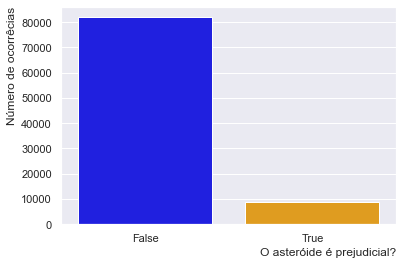

In [59]:
sns.countplot(x=dados['hazardous'], palette=['blue', 'orange'])
plt.xlabel('O asteróide é prejudicial?', loc='right')
plt.ylabel('Número de ocorrêcias', loc='top')
plt.show()

Tendo em mente que 'True' significa que o asteróide é potencialmente perigoso e 'False' que não há risco, o gráfico representado acima deixa explícito que, de todos os fragmentos de corpos celestes acompanhados, o número daqueles que podem ser prejudiciais a terra é pequeno, ficando abaixo das 10000 ocorrências (isto é, pouco mais de 10% do total analisado). Sabendo que esta coluna retrata justamente o nosso target (isto é, aquilo que queremos predizer), resta investigar as outras features do dataset para determinar aquelas que mais se relacionam à prejudicialidade dos asteróides.

## Feature 'relative_velocity'

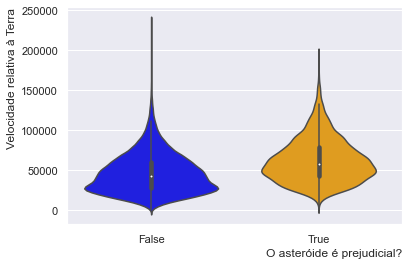

In [60]:
cor={False:'blue',True:'orange'}
sns.violinplot(x=dados['hazardous'], y=dados['relative_velocity'], palette=cor)
plt.xlabel('O asteróide é prejudicial?', loc='right')
plt.ylabel('Velocidade relativa à Terra', loc='top')
plt.show()

Pela observação do violinplot acima, podemos constatar que, em geral, fragmentos de corpos celestes com velocidades relativas à terra maiores são mais nocivos. Isso ocorre porque, embora os formatos de ambas as representações sejam similares (especialmente na faixa entre 50000 e 100000), é possível notar que, enquanto o gráfico em azul mostra-se bastante largo até o valor 50000, o gráfico laranja apresenta-se comparativamente mais robusto a partir da velocidade 100000. Portanto, temos que asteróides menos velozes (abaixo de 25000) são, em geral, menos perigosos; já os mais velozes (acima de 100000) são, em sua maioria, mais perigosos.

## Feature 'miss_distance'

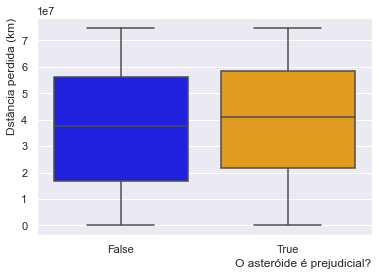

In [61]:
cor={False:'blue',True:'orange'}
sns.boxplot(x=dados['hazardous'], y=dados['miss_distance'], palette=cor)
plt.xlabel('O asteróide é prejudicial?', loc='right')
plt.ylabel('Dstância perdida (km)', loc='top')
plt.show()

Através do boxplot retratado podemos constatar que, surpreendentemente, a distância perdida do asteróide não parece tão relevante para a definição de sua prejudicialidade. Assim, a diferença entre os diagramas azul e laranja são quase nulas, podendo ser observada apenas pelas desigualdades entre os primeiros quartis (azul mais baixo) e terceiros quartis (laranja um pouco mais alto), que, em maior escala, poderiam indicar que maior a distância perdida, mais perigoso será o asteróide.

## Feature 'absolute_magnitude'

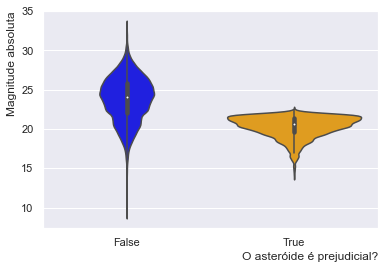

In [62]:
cor={False:'blue',True:'orange'}
sns.violinplot(x=dados['hazardous'], y=dados['absolute_magnitude'], palette=cor)
plt.xlabel('O asteróide é prejudicial?', loc='right')
plt.ylabel('Magnitude absoluta', loc='top')
plt.show()

Já em relação à magnitude absoluta, notamos, primeiramente, que os valores mais frequentemente encontrados no dataset variam entre os números 17 e 28. Além disso, temos que o intervalo entre 19 e 22 demonstra ser o mais prejudicial, já que, nessa parte, o violinplot em laranja é expressivamente mais grosso que o azul, indicando não apenas que asteróides dessa magnitude são mais frequentes como também oferecem maior risco ao planeta Terra. Aproximadamente a partir da magnitude 22, porém, os valores laranjas extinguem-se abruptamente, em contraste com a espessura crescente (embora moderada) do gráfico azul. Vale lembrar que os valores em análise referem-se às medidas dos brilhos de cada corpo celeste em questão, e, quanto maior o número da magnitude, menor o brilho aparente do objeto, e vice-versa. Concluí-se, portanto, que os asteróides mais brilhantes de nosso dataset (ou seja, menor magnitude) são, em geral, mais perigosos que os menos brilhantes.

## Feature 'est_diameter_min'

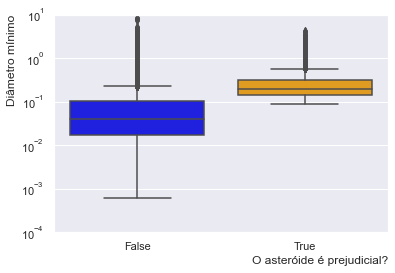

In [63]:
cor={False:'blue',True:'orange'}
sns.boxplot(x=dados['hazardous'], y=dados['est_diameter_min'], palette=cor)
plt.xlabel('O asteróide é prejudicial?', loc='right')
plt.ylabel('Diâmetro mínimo', loc='top')
plt.yscale('log')
plt.ylim(0.0001, 10)
plt.show()

No caso da estimativa do diametros mínimo, os boxplots acima dividem, grossamente, dois conjuntos mais frequentes de asteróides: aqueles cujo diâmetro mínimo é estimado entre 0,01 e 0,1, e aqueles cuja estimativa é um pouco maior que 0,1. Embora os diversos outliers deixem claro que tal classificação é bastante generalizada e não diz respeito a todos os fragmentos de corpos celestes, a observação do gráfico é útil por revelar-nos que, em geral, quanto menor o asteróide, menos risco ele representará - ideia reforçada também pelas linhas de mínimo e máximo de cada diagrama, que mostra como a amplitude dos dados varia para menos no boxplot azul e para mais no boxplot laranja.

## Feature 'est_diameter_max'

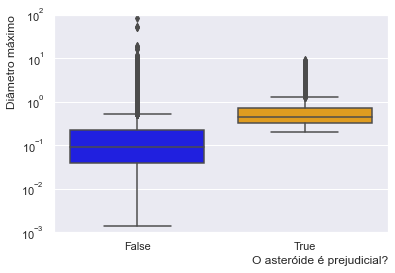

In [64]:
cor={False:'blue',True:'orange'}
sns.boxplot(x=dados['hazardous'], y=dados['est_diameter_max'], palette=cor)
plt.xlabel('O asteróide é prejudicial?', loc='right')
plt.ylabel('Diâmetro máximo', loc='top')
plt.yscale('log')
plt.ylim(0.001, 100)
plt.show()

Em concordância com o tópico anterior, o gráfico de estimativa de diametros máximos também revela a noção de que, em geral, quanto menor o asteróide, menos risco ele representará.

# Conclusão da análise de dados
Após criarmos diversos gráficos e analisarmos dados variados, podemos chegar a algumas conclusões quanto às relações existentes entre a nocividade de cada asteróide e outras features presentes no conjunto de dados. Pelo estudo comparativo das colunas (mais especificamente, pela comparação das diferentes características dos fragmentos de corpos celestes com a feature relativa ao perigo representado por ele), podemos enumerar algumas propensões gerais que são importantes para o nosso target:

- Asteróides menos velozes (abaixo de 25000) são, em geral, menos nocivos; já os mais velozes (acima de 100000) são, em sua maioria, mais nocivos;
- Os asteróides de menor magnitude de nosso dataset são, em geral, mais perigosos que aqueles de maior magnitude;
- Em geral, fragmentos de corpos celestes com menores diâmetros mínimos estimados são menos prejudiciais, e vice-versa;
- Em geral, fragmentos de corpos celestes com menores diâmetros máximos estimados são menos prejudiciais, e vice-versa.

Com tais informações, podemos concluir que, mais do que simplesmente a distância que o objeto está da terra e rota traçada por ele, a nocividade do asteróide pode ser caracterizada a partir de três principais pontos: sua velocidade, sua magnitude e seu tamanho. Assim, com a ajuda de diferentes gráficos e análises, fomos capazes de compreender de modo mais profundo questões inicialmente "escondidas" em dados dispersos. Com isso, agora poderemos criar uma rede neural que poderá predizer quais asteróides são prejudiciais e quais não o são.

# Tratamento de dados para criação de rede neural
Além da limpeza e análise dos dados, devemos ainda realizar certas "adaptações" no dataset para utilizarmos uma rede neural mais facilmente.

## One-hot encoding
Antes de prosseguir, precisamos adaptar os dados categóricos que serão usados em nossa rede neural, que melhor suporta valores contínuos. Assim, utilizaremos o one-hot-encoding para converter as informações em 'orbiting_body', 'sentry_object' e 'hazardous' em múltiplas colunas de valores binários (1 para sim, 0 para não). Observe:

In [65]:
one_hot_dados = pd.get_dummies(dados, columns=['orbiting_body', 'sentry_object', 'hazardous'])

## Divisão entre preditores e alvo
Agora, separaremos os dados em X (por convenção, o 'X' é escrito em caixa alta) e y, sendo que o primeiro representa as colunas usadas para fazer as predições e o segundo a coluna target, ou aquela que queremos predizer.

In [106]:
X = one_hot_dados.drop(columns = ['id', 'name', 'orbiting_body_Earth', 'sentry_object_False', 'hazardous_False', 'hazardous_True'])    # Cria uma variável com os valores usados para prever o target, livre das colunas pouco relevantes 
y = one_hot_dados['hazardous_True']    # Cria uma variável apenas com os valores do target

## Normalização de dados
A normalização de dados atravéz da função StandardScaler também é essencial em nosso caso, já que as diferentes características de nosso dataset encontram-se em diferentes unidades de medida e apresentam valores muito variados entre si. Veja abaixo:

In [107]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Divisão entre treino e teste

Por último, dividiremos os dados em treino (70% do dataset) e teste (30% do dataset), que posteriormente será utilizado para avaliarmos o modelo.

In [108]:
from sklearn.model_selection import train_test_split

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

# Construção de uma rede neural com keras e tensorflow
Agora que nosso dataset encontra-se limpo, analisado e tratado, podemos, finalmente, construir a nossa rede neural. Para isso, utilizaremos o keras, ferramenta simples e intuitiva que têm muito a oferecer em casos de problemas menores como o nosso.

In [109]:
import tensorflow as tf
from tensorflow import keras

Após importarmos o keras, podemos construir e treinar a nossa rede neural seguindo apenas três etapas: primeiro, criaremos o nosso modelo e estabeleceremos suas 4 camadas; depois, utilizaremos a função 'compile' para definir a função de custo, seu otimizador e duas métricas que avaliam a performance por outras perspectivas além do custo; e, por último, treinaremos nosso modelo. Lembre-se de ler os comentários, e vamos ao código!

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_metrics

model = Sequential()    # Cria um modelo do tipo 'sequential', mais comum e simples, em que cada camada recebe exatamente um input e retorna apenas um output (input da camada seguinte). Em seguida, Iremos adicionar suas camadas pelo método 'add()'. 
model.add(Dense(15, input_dim=5, activation='relu'))    # Define o tamanho do output, o input da primeira camada e a ativação mais básica 'relu'.
model.add(Dense(10, activation='relu'))    # Camada oculta em que não é necessário especificar o input, já que a função é do tipo 'sequential' e usará o output da camada anterior. 
model.add(Dense(10, activation='relu'))    # Outra camada oculta. 
model.add(Dense(2, activation='softmax'))    # Camada final, que tem como output o número de classificações possíveis (os asteróides são perigosos ou não?) e ativação 'softmax' por se tratar de um problema distribucional.

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', keras_metrics.recall()])    # Define a função de custo, com otimizador básico 'adam' e métricas acurácia e revocação, sendo a última importante para averiguar se nosso modelo está dando a devida importância aos Falsos Positivos.

tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn


Finalmente, podemos treinar o nosso modelo pelo seguinte comando:

In [111]:
model.fit(X_treino, y_treino, epochs=5)

Epoch 1/5
1988/1988 [==============================] - 4s 2ms/step - loss: 0.2191 - accuracy: 0.9017 - recall: 0.9616
Epoch 2/5
1988/1988 [==============================] - 7s 3ms/step - loss: 0.1877 - accuracy: 0.9115 - recall: 0.8772
Epoch 3/5
1988/1988 [==============================] - 7s 3ms/step - loss: 0.1860 - accuracy: 0.9125 - recall: 0.8495
Epoch 4/5
1988/1988 [==============================] - 7s 3ms/step - loss: 0.1852 - accuracy: 0.9125 - recall: 0.8387
Epoch 5/5
1988/1988 [==============================] - 7s 3ms/step - loss: 0.1845 - accuracy: 0.9129 - recall: 0.8340


Observando o histórico de valores no treinamento, temos que, embora lentamente, o custo está diminuindo e a acurácia está aumentando. Nosso único empecilho seria, então, o valor apresentado em revocação, decrescente ao invés de crescente. Ainda assim, temos uma revocação relativamente alta, importante neste problema por ser a responsável por avaliar a presença de Falsos Positivos, isto é, asteróides perigosos indevidamente classificados como inofensivos. Além dos valores apresentados durante o treinamento, devemos também verificar se houve qualquer tipo de overfitting através do uso dos dados de teste, que verificarão o desempenho de nosso modelo em um conjunto de dados completamente novo.

In [113]:
val_loss, val_accuracy, val_recall = model.evaluate(X_teste, y_teste)
print(val_loss, val_accuracy, val_recall)

852/852 [==============================] - 1s 1ms/step - loss: 0.1856 - accuracy: 0.9108 - recall: 0.8342
0.18562278151512146 0.9107922911643982 0.8341508507728577


Vemos agora que o desempenho do modelo nos dados de teste é mantido, pois, embora exista uma perda em relação aos dados de treino, ela é mínima. Assim, podemos considerar que o modelo cumpre satisfatoriamente seu papel classificatório.